Import & konfigurasi folder

In [13]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter, find_peaks  # jika error: pip install scipy

# -----------------------------
# 1. Path input torso (dari kamu)
# -----------------------------
FOLDER_TORSO = r"E:\1.Clustering_TA\output_clustering\02_torso_per_frame"

# -----------------------------
# 2. Root output untuk gait fitur (baru, beda dari output_clustering)
# -----------------------------
OUTPUT_GAIT_ROOT = r"E:\1.Clustering_TA\output_gait_features"

# -----------------------------
# 3. Daftar subjek
# -----------------------------
SUBJECTS = ["Afi", "Kinan", "Miftah"]

# -----------------------------
# 4. Buat 3 folder per subjek:
#    - gait_signal_per_frame
#    - gait_features_per_step
#    - gait_plots (gambar PNG)
# -----------------------------
OUTPUT_DIRS = {}

for subj in SUBJECTS:
    subj_root = os.path.join(OUTPUT_GAIT_ROOT, subj)
    dir_signal = os.path.join(subj_root, "gait_signal_per_frame")
    dir_step   = os.path.join(subj_root, "gait_features_per_step")
    dir_plots  = os.path.join(subj_root, "gait_plots")

    os.makedirs(dir_signal, exist_ok=True)
    os.makedirs(dir_step, exist_ok=True)
    os.makedirs(dir_plots, exist_ok=True)

    OUTPUT_DIRS[subj] = {
        "root": subj_root,
        "signal": dir_signal,
        "step": dir_step,
        "plots": dir_plots,
    }

print("Struktur folder OUTPUT_GAIT_ROOT:")
for subj, d in OUTPUT_DIRS.items():
    print(f"- {subj}")
    for k, v in d.items():
        print(f"   {k:8s}: {v}")


Struktur folder OUTPUT_GAIT_ROOT:
- Afi
   root    : E:\1.Clustering_TA\output_gait_features\Afi
   signal  : E:\1.Clustering_TA\output_gait_features\Afi\gait_signal_per_frame
   step    : E:\1.Clustering_TA\output_gait_features\Afi\gait_features_per_step
   plots   : E:\1.Clustering_TA\output_gait_features\Afi\gait_plots
- Kinan
   root    : E:\1.Clustering_TA\output_gait_features\Kinan
   signal  : E:\1.Clustering_TA\output_gait_features\Kinan\gait_signal_per_frame
   step    : E:\1.Clustering_TA\output_gait_features\Kinan\gait_features_per_step
   plots   : E:\1.Clustering_TA\output_gait_features\Kinan\gait_plots
- Miftah
   root    : E:\1.Clustering_TA\output_gait_features\Miftah
   signal  : E:\1.Clustering_TA\output_gait_features\Miftah\gait_signal_per_frame
   step    : E:\1.Clustering_TA\output_gait_features\Miftah\gait_features_per_step
   plots   : E:\1.Clustering_TA\output_gait_features\Miftah\gait_plots


Helper: hitung sinyal gait per frame & fitur per step

In [15]:
from typing import Tuple, Dict, Optional

# -----------------------------
# FPS radar (ISI kalau sudah tahu)
# contoh: FPS = 20.0
# kalau belum tahu: biarkan None → waktu dalam "frame units"
# -----------------------------
FPS = None  # ganti misalnya 20.0 kalau sudah tahu

# -----------------------------
# Parameter smoothing & step detection
# -----------------------------
SAVGOL_WINDOW = 7        # harus ganjil: 5/7/9
SAVGOL_POLY = 2
MIN_PEAK_PROMINENCE = 0.005
MIN_PEAK_DISTANCE_FRAMES = 5


def compute_gait_signal_per_frame(
    df_torso: pd.DataFrame,
    trial_name: str,
    fps: Optional[float] = FPS,
) -> Tuple[pd.DataFrame, np.ndarray]:
    """
    Hitung sinyal gait per frame dari centroid torso.
    - delta_d      : ||c_t - c_{t-1}||   (m)
    - v_step_frame : delta_d / dt        (m/s) kalau fps diketahui
    - v_step_smooth: sinyal v_step_frame yang sudah di-smoothing
    - step_flag    : 1 di frame heel-strike (peak)
    - step_index   : index langkah (1,2,3,...)
    """
    df = df_torso.copy()
    df = df.sort_values("frame").reset_index(drop=True)

    # pastikan kolom yang dibutuhkan ada
    required = ["frame", "torso_x", "torso_y", "torso_z"]
    for col in required:
        if col not in df.columns:
            raise ValueError(f"Kolom '{col}' tidak ditemukan di trial {trial_name}")

    # centroid torso per frame
    coords = df[["torso_x", "torso_y", "torso_z"]].to_numpy()

    # vektor perpindahan antar frame
    delta_vec = np.diff(coords, axis=0, prepend=coords[[0], :])
    delta_d = np.linalg.norm(delta_vec, axis=1)  # meter per frame

    df["delta_d"] = delta_d

    # konversi ke kecepatan
    if fps is not None:
        df["v_step_frame"] = delta_d * fps      # m/s
        vel_signal = df["v_step_frame"].to_numpy()
    else:
        df["v_step_frame"] = delta_d            # m/frame (unit frame)
        vel_signal = df["v_step_frame"].to_numpy()

    # smoothing dengan Savitzky–Golay
    if len(df) < 3:
        df["v_step_smooth"] = vel_signal
    else:
        window = min(SAVGOL_WINDOW,
                     len(df) if len(df) % 2 == 1 else len(df) - 1)
        if window < 3:
            df["v_step_smooth"] = vel_signal
        else:
            df["v_step_smooth"] = savgol_filter(
                vel_signal,
                window_length=window,
                polyorder=SAVGOL_POLY,
            )

    # deteksi heel-strike sebagai peak v_step_smooth
    peaks, _ = find_peaks(
        df["v_step_smooth"].to_numpy(),
        prominence=MIN_PEAK_PROMINENCE,
        distance=MIN_PEAK_DISTANCE_FRAMES,
    )

    df["step_flag"] = 0
    df["step_index"] = -1
    for i, p in enumerate(peaks, start=1):
        df.at[p, "step_flag"] = 1
        df.at[p, "step_index"] = i

    return df, peaks


def compute_step_features(
    df_signal: pd.DataFrame,
    trial_name: str,
    fps: Optional[float] = FPS,
) -> Tuple[pd.DataFrame, Dict]:
    """
    Hitung fitur per step & ringkasan per trial dari sinyal frame-level.
    - T_step: waktu antar heel-strike (detik kalau fps diketahui)
    - L_step_m: jarak torso antar heel-strike (m)
    - v_walk_step: L_step / T_step (m/s)
    """
    peaks_idx = df_signal.index[df_signal["step_flag"] == 1].to_numpy()

    if len(peaks_idx) < 2:
        print(f"[WARNING] {trial_name}: jumlah step < 2, fitur tidak stabil.")

    frames_peaks = df_signal.loc[peaks_idx, "frame"].to_numpy()
    coords_peaks = df_signal.loc[peaks_idx,
                                 ["torso_x", "torso_y", "torso_z"]].to_numpy()

    step_rows = []
    for k in range(len(peaks_idx) - 1):
        f0, f1 = frames_peaks[k], frames_peaks[k + 1]
        c0, c1 = coords_peaks[k], coords_peaks[k + 1]

        step_frames = f1 - f0
        if fps is not None:
            T_step = step_frames / fps   # detik
        else:
            T_step = step_frames         # dalam frame

        L_step = float(np.linalg.norm(c1 - c0))  # meter

        if fps is not None and T_step > 0:
            v_walk_step = L_step / T_step
        else:
            v_walk_step = float("nan")

        step_rows.append({
            "trial": trial_name,
            "step_id": k + 1,
            "frame_start": int(f0),
            "frame_end": int(f1),
            "T_step": float(T_step),
            "T_step_unit": "s" if fps is not None else "frames",
            "L_step_m": L_step,
            "v_walk_step": v_walk_step,
        })

    df_steps = pd.DataFrame(step_rows)

    # ringkasan per trial
    N_step = len(peaks_idx)
    if len(df_steps) > 0:
        mean_T_step = df_steps["T_step"].mean()
        mean_L_step = df_steps["L_step_m"].mean()
        if fps is not None:
            cadence = 60.0 / mean_T_step       # steps/min
            mean_v_walk = df_steps["v_walk_step"].mean()
        else:
            cadence = float("nan")
            mean_v_walk = float("nan")
    else:
        mean_T_step = float("nan")
        mean_L_step = float("nan")
        cadence = float("nan")
        mean_v_walk = float("nan")

    summary = {
        "trial": trial_name,
        "N_step": int(N_step),
        "mean_T_step": mean_T_step,
        "mean_T_step_unit": "s" if fps is not None else "frames",
        "mean_L_step_m": mean_L_step,
        "cadence_spm": cadence,
        "mean_v_walk": mean_v_walk,
        "v_walk_unit": "m/s" if fps is not None else "m/frame",
    }

    return df_steps, summary


def plot_gait_signals(
    df_signal: pd.DataFrame,
    peaks_idx: np.ndarray,
    title: str = "",
    save_path: Optional[str] = None,
) -> None:
    """
    Plot:
    - Torso Y vs frame (+ garis vertikal di step)
    - v_step_smooth vs frame (+ marker heel-strike)
    """
    frames = df_signal["frame"].to_numpy()
    torso_y = df_signal["torso_y"].to_numpy()
    v_step_smooth = df_signal["v_step_smooth"].to_numpy()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Posisi torso Y
    ax1.plot(frames, torso_y, marker="o", linewidth=1)
    for p in peaks_idx:
        ax1.axvline(frames[p], color="r", linestyle="--", alpha=0.4)
    ax1.set_ylabel("Torso Y (m)")
    ax1.set_title(f"Torso Y vs Frame {title}")
    ax1.grid(True)

    # Sinyal kecepatan langkah
    ax2.plot(frames, v_step_smooth, marker="o", linewidth=1)
    if len(peaks_idx) > 0:
        ax2.plot(frames[peaks_idx], v_step_smooth[peaks_idx], "ro", label="Heel-strike")
    ax2.axhline(0.0, color="k", linewidth=0.8)
    ax2.set_xlabel("Frame")
    ax2.set_ylabel("v_step_smooth (Δd/Δt)")
    ax2.set_title("Sinyal langkah (smoothed) & Step")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        print(f"Plot disimpan ke: {save_path}")
    plt.show()


Proses 1 trial contoh (cek visual dan nilai fitur)

Daftar file torso untuk Kinan:
0: Kinan_Jalan10_clustered_torso.csv
1: Kinan_Jalan11_clustered_torso.csv
2: Kinan_Jalan12_clustered_torso.csv
3: Kinan_Jalan13_clustered_torso.csv
4: Kinan_Jalan14_clustered_torso.csv
5: Kinan_Jalan15_clustered_torso.csv
6: Kinan_Jalan16_clustered_torso.csv
7: Kinan_Jalan17_clustered_torso.csv
8: Kinan_Jalan18_clustered_torso.csv
9: Kinan_Jalan19_clustered_torso.csv
10: Kinan_Jalan1_clustered_torso.csv
11: Kinan_Jalan20_clustered_torso.csv
12: Kinan_Jalan21_clustered_torso.csv
13: Kinan_Jalan22_clustered_torso.csv
14: Kinan_Jalan23_clustered_torso.csv
15: Kinan_Jalan24_clustered_torso.csv
16: Kinan_Jalan25_clustered_torso.csv
17: Kinan_Jalan26_clustered_torso.csv
18: Kinan_Jalan27_clustered_torso.csv
19: Kinan_Jalan28_clustered_torso.csv
20: Kinan_Jalan29_clustered_torso.csv
21: Kinan_Jalan2_clustered_torso.csv
22: Kinan_Jalan30_clustered_torso.csv
23: Kinan_Jalan31_clustered_torso.csv
24: Kinan_Jalan32_clustered_torso.csv
25: Kinan_Jalan33_clustered_tor

,frame,torso_cluster_id,torso_x,torso_y,torso_z,num_points_torso,is_held_from_prev,delta_d,v_step_frame,v_step_smooth,step_flag,step_index
0,12,0,0.720084,0.477060,1.422200,6,0,0.000000,0.000000,0.030729,0,-1
1,13,0,0.684424,0.548467,1.470647,23,0,0.093369,0.093369,0.082395,0,-1
2,14,0,0.611629,0.531669,1.260041,18,0,0.223464,0.223464,0.127748,0,-1
3,15,0,0.623616,0.599179,1.360943,31,0,0.121994,0.121994,0.166787,0,-1
4,16,0,0.629884,0.611773,1.251042,8,0,0.110798,0.110798,0.203468,1,1



>> Step features (per step):


,trial,step_id,frame_start,frame_end,T_step,T_step_unit,L_step_m,v_walk_step
0,Kinan_Jalan10_clustered_torso,1,16,22,6.0,frames,0.258599,NaN
1,Kinan_Jalan10_clustered_torso,2,22,28,6.0,frames,0.260455,NaN
2,Kinan_Jalan10_clustered_torso,3,28,36,8.0,frames,0.344192,NaN
3,Kinan_Jalan10_clustered_torso,4,36,42,6.0,frames,0.511365,NaN
4,Kinan_Jalan10_clustered_torso,5,42,48,6.0,frames,0.422360,NaN
5,Kinan_Jalan10_clustered_torso,6,48,62,14.0,frames,0.548091,NaN
6,Kinan_Jalan10_clustered_torso,7,62,70,8.0,frames,0.181417,NaN



>> Summary trial:
{'trial': 'Kinan_Jalan10_clustered_torso', 'N_step': 8, 'mean_T_step': 7.714285714285714, 'mean_T_step_unit': 'frames', 'mean_L_step_m': 0.36092570215560377, 'cadence_spm': nan, 'mean_v_walk': nan, 'v_walk_unit': 'm/frame'}


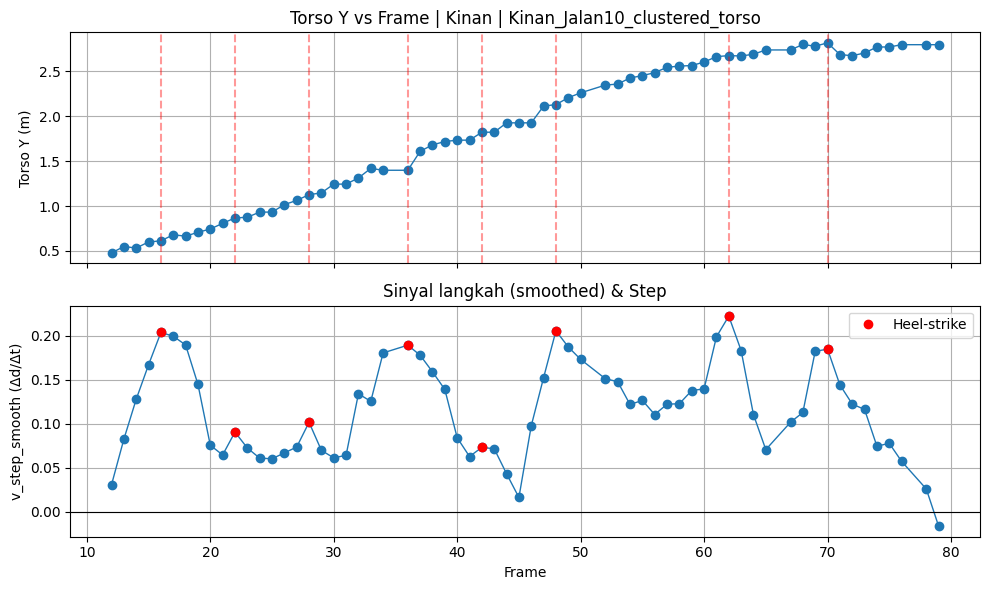

In [16]:
# -----------------------------
# Pilih subjek & trial untuk contoh
# -----------------------------
example_subject = "Kinan"  # ganti "Afi"/"Miftah" kalau mau
pattern_example = os.path.join(FOLDER_TORSO, f"{example_subject}_*_torso.csv")
example_files = sorted(glob.glob(pattern_example))

print(f"Daftar file torso untuk {example_subject}:")
for i, f in enumerate(example_files):
    print(f"{i}: {os.path.basename(f)}")

# pilih index file yang mau dicoba
example_idx = 0  # ganti kalau mau trial lain
example_torso_csv = example_files[example_idx]
print("\nFile contoh:", example_torso_csv)

# baca torso & buang frame noise
df_torso = pd.read_csv(example_torso_csv)
if "torso_cluster_id" in df_torso.columns:
    df_torso = df_torso[df_torso["torso_cluster_id"] != -1].copy()

base_name = os.path.splitext(os.path.basename(example_torso_csv))[0]

# ---- hitung gait signal per frame ----
df_gait_frame, peaks_idx = compute_gait_signal_per_frame(
    df_torso,
    trial_name=base_name,
    fps=FPS,
)

# ---- hitung fitur per step + ringkasan ----
df_steps, summary = compute_step_features(
    df_gait_frame,
    trial_name=base_name,
    fps=FPS,
)

print("\n>> Gait signal per frame (head):")
display(df_gait_frame.head())

print("\n>> Step features (per step):")
display(df_steps)

print("\n>> Summary trial:")
print(summary)

# -----------------------------
# Plot visual contoh saja
# -----------------------------
plot_title = f"| {example_subject} | {base_name}"
plot_gait_signals(df_gait_frame, peaks_idx,
                  title=plot_title,
                  save_path=None)  # kalau mau disimpan, isi path


Batch: proses SEMUA file per subjek → simpan ke 3 folder per subjek

In [17]:
all_summaries = []  # kalau mau simpan ringkasan semua trial

for subj in SUBJECTS:
    print(f"\n============================")
    print(f"Proses subjek: {subj}")
    print(f"============================")

    pattern = os.path.join(FOLDER_TORSO, f"{subj}_*_torso.csv")
    torso_files = sorted(glob.glob(pattern))

    if not torso_files:
        print(f"Tidak ada file torso untuk subjek {subj}.")
        continue

    subj_dirs = OUTPUT_DIRS[subj]

    for torso_csv in torso_files:
        base_name = os.path.splitext(os.path.basename(torso_csv))[0]
        print(f"\n>> Proses file: {base_name}")

        df_torso = pd.read_csv(torso_csv)
        if "torso_cluster_id" in df_torso.columns:
            df_torso = df_torso[df_torso["torso_cluster_id"] != -1].copy()

        if len(df_torso) < 5:
            print("   Peringatan: frame valid sangat sedikit, dilewati.")
            continue

        # 1) gait signal per frame
        df_gait_frame, peaks_idx = compute_gait_signal_per_frame(
            df_torso,
            trial_name=base_name,
            fps=FPS,
        )

        # 2) fitur per step + summary
        df_steps, summary = compute_step_features(
            df_gait_frame,
            trial_name=base_name,
            fps=FPS,
        )
        all_summaries.append(summary)

        # simpan sinyal per frame
        out_signal_csv = os.path.join(
            subj_dirs["signal"],
            f"{base_name}_gait_frame.csv"
        )
        df_gait_frame.to_csv(out_signal_csv, index=False)
        print(f"   [OK] gait_signal_per_frame -> {out_signal_csv}")

        # simpan fitur per step
        out_step_csv = os.path.join(
            subj_dirs["step"],
            f"{base_name}_gait_step.csv"
        )
        df_steps.to_csv(out_step_csv, index=False)
        print(f"   [OK] gait_features_per_step -> {out_step_csv}")

        # TIDAK ADA plot_gait_signals DI SINI (biar tidak banjir gambar)

# opsional: simpan ringkasan semua trial
# summary_df = pd.DataFrame(all_summaries)
# summary_csv = os.path.join(OUTPUT_ROOT, "gait_summary_all_trials.csv")
# summary_df.to_csv(summary_csv, index=False)
# print(f"\n[OK] Simpan ringkasan semua trial -> {summary_csv}")



Proses subjek: Afi

>> Proses file: Afi_Jalan10_clustered_torso
   [OK] gait_signal_per_frame -> E:\1.Clustering_TA\output_gait_features\Afi\gait_signal_per_frame\Afi_Jalan10_clustered_torso_gait_frame.csv
   [OK] gait_features_per_step -> E:\1.Clustering_TA\output_gait_features\Afi\gait_features_per_step\Afi_Jalan10_clustered_torso_gait_step.csv

>> Proses file: Afi_Jalan11_clustered_torso
   [OK] gait_signal_per_frame -> E:\1.Clustering_TA\output_gait_features\Afi\gait_signal_per_frame\Afi_Jalan11_clustered_torso_gait_frame.csv
   [OK] gait_features_per_step -> E:\1.Clustering_TA\output_gait_features\Afi\gait_features_per_step\Afi_Jalan11_clustered_torso_gait_step.csv

>> Proses file: Afi_Jalan12_clustered_torso
   [OK] gait_signal_per_frame -> E:\1.Clustering_TA\output_gait_features\Afi\gait_signal_per_frame\Afi_Jalan12_clustered_torso_gait_frame.csv
   [OK] gait_features_per_step -> E:\1.Clustering_TA\output_gait_features\Afi\gait_features_per_step\Afi_Jalan12_clustered_torso_gait

Sample trial: Afi_Jalan10_clustered_torso


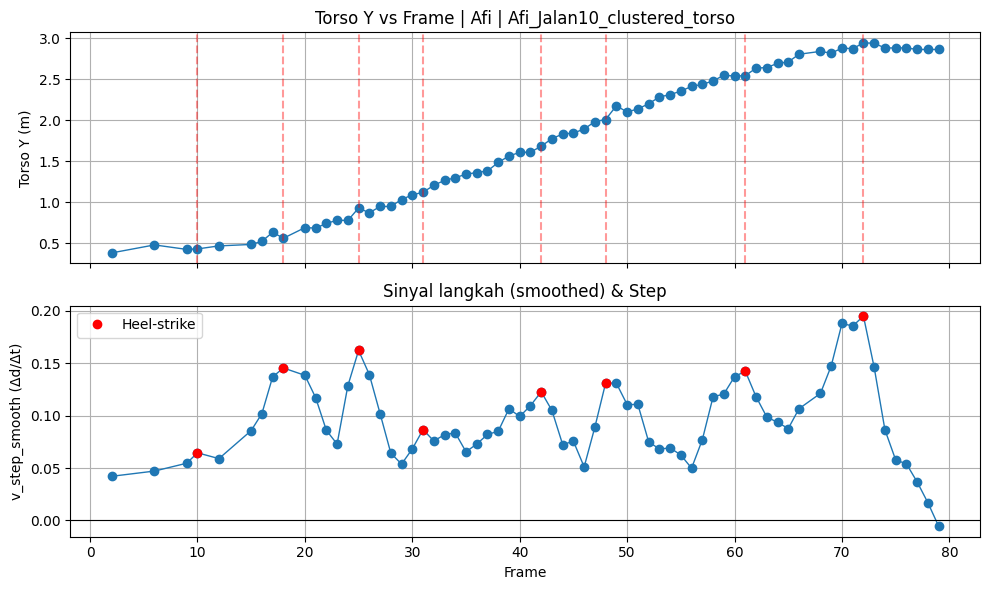

In [18]:
# ====== PLOT SAMPLE SAJA ======

SAMPLE_SUBJECT = "Afi"
SAMPLE_TRIAL_PATTERN = "Jalan10"  # atau "Jalan8", dsb.

pattern = os.path.join(FOLDER_TORSO, f"{SAMPLE_SUBJECT}_{SAMPLE_TRIAL_PATTERN}*_torso.csv")
sample_files = sorted(glob.glob(pattern))
if not sample_files:
    raise FileNotFoundError(f"Tidak ada file dengan pola: {pattern}")

sample_csv = sample_files[0]
base_name = os.path.splitext(os.path.basename(sample_csv))[0]
print("Sample trial:", base_name)

df_torso = pd.read_csv(sample_csv)
if "torso_cluster_id" in df_torso.columns:
    df_torso = df_torso[df_torso["torso_cluster_id"] != -1].copy()

df_gait_frame, peaks_idx = compute_gait_signal_per_frame(df_torso, trial_name=base_name, fps=FPS)

# kalau kamu masih punya fungsi plot_gait_signals, panggil di sini:
plot_title = f"| {SAMPLE_SUBJECT} | {base_name}"
plot_gait_signals(df_gait_frame, peaks_idx, title=plot_title, save_path=None)
